# 🎯 Few-shot fungi classification
This notebook provides a simple baselines for the few-shot classification of fungi. Both baselines require you to pre-extracted features using any encoder, e.g., BioCLIP, and DINOv2. For the classification, we provide:
1. **Centroid-based classifier** computes the class prototype by averaging the features of the support set. The class prototype is then used to classify the query set.
2. **Nearest neighbour classifier** classifies the query set by finding the nearest neighbour in the support set.

## ⚙️ Experiment Setup
Install and import for the required libraries. 
Setting up pathing etc.

We also set path to dataset (which are downloaded automatically).

In [1]:
###Install required libraries:
!pip install git+https://github.com/mlfoundations/open_clip.git
!pip install faiss-gpu -qq

  Cloning https://github.com/mlfoundations/open_clip.git to /tmp/pip-req-build-un0sm65j
  Running command git clone --filter=blob:none --quiet https://github.com/mlfoundations/open_clip.git /tmp/pip-req-build-un0sm65j
  Resolved https://github.com/mlfoundations/open_clip.git to commit 1a058f7919bd59097dcd4753999fb8ec72bf6b27
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00
  Created wheel for open_clip_torch: filename=open_clip_torch-2.32.0-py3-none-any.whl size=1533317 sha256=2fcb92e2ba0d6eb648c41ac3be168dd1bb62dbc440f4531cbcf2eda21e4c8dcc
  Stored in directory: /tmp/pip-ephem-wheel-cache-yvry0swo/wheels/2c/7e/51/c9df485368875ebcc36099a02e2cb98922dec2cba6be26917f
Successfully built open_clip_torch
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 20.5 MB/s eta 0:00:00:00:0100:01


In [2]:
import os
import json
import yaml
from pathlib import Path
from types import SimpleNamespace
import argparse

import numpy as np
import pandas as pd
import torch
import faiss

import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torchvision import transforms as tfms
import torchvision.transforms as T
import open_clip

from typing import Sequence, Tuple, Any, Dict, List, Optional, Union
import importlib

In [3]:
# path to fungitatsic dataset
data_path = '/kaggle/input/fungi-clef-2025/'


## 🔬 1. Define BioCLIP feature extractor

### BioCLIP: A Deep Learning Model for Biological Image Feature Extraction

🔗 [BioCLIP](https://huggingface.co/imageomics/bioclip) is a deep learning model designed for extracting high-quality feature embeddings from biological images. It is built on the **Contrastive Language-Image Pretraining (CLIP) framework**, specifically tailored for biological applications. The model is hosted on the **Hugging Face Hub**, making it easily accessible for researchers and developers working with biological image data.

#### Purpose and Applications

BioCLIP is designed to bridge the gap between visual data and semantic understanding in biological research. Its main applications include:

- **Automated Species Identification**: Extracting meaningful features from images of fungi, plants, or animals to assist in species recognition.
- **Biodiversity Monitoring**: Enabling large-scale ecological studies by processing images from camera traps or field surveys.
- **Medical and Microscopy Analysis**: Supporting tasks like cell classification, pathology slide analysis, and disease detection.
- **Bioinformatics and AI-powered Conservation**: Facilitating the development of models that leverage image-based insights for conservation efforts.

#### Key Features

- **Pretrained on Biological Datasets**: Unlike general-purpose CLIP models, BioCLIP has been fine-tuned on biological image datasets, improving its performance in domain-specific tasks.
- **Feature Extraction for Downstream Tasks**: Generates robust, high-dimensional embeddings that can be used for classification, clustering, or retrieval.
- **L2-Normalized Embeddings**: Ensures that extracted feature vectors have unit length, making them suitable for similarity comparisons.
- **Seamless Integration with PyTorch**: Designed to work within PyTorch-based workflows for machine learning and deep learning applications.

#### Code and Implementation

The implementation of BioCLIP for feature extraction is available in the following repository:

This model can be integrated into Python workflows using `open_clip`, allowing users to load the model, preprocess images, and extract embeddings efficiently.

In [4]:
class BioCLIP(torch.nn.Module):

    def __init__(self, device):
        """
        Initialize the BioCLIP feature extractor.
        """
        super(BioCLIP, self).__init__()
        self.device = device
        self.model = None
        self.processor = None
        self.size = (224, 224)

    def load(self):
        """
        Load the BioCLIP model and its associated image processor.
        
        The model is loaded from the Hugging Face Hub and moved to the specified device.
        """
        self.model, _, self.processor = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip')
        self.model.to(self.device)

    def extract_features(self, image):
        """
        Extract normalized feature embeddings from a given image.

        Args:
            image (PIL.Image.Image): The input image from which to extract features.

        Returns:
            torch.Tensor: A normalized feature embedding vector for the input image.

        Raises:
            ValueError: If the model has not been loaded prior to calling this method.
        """
        if self.model is None:
            raise ValueError('Model not loaded')
        image = image.resize(self.size, Image.BICUBIC)
        image_tensor_proc = self.processor(image)[None]
        features = self.model.encode_image(image_tensor_proc.to(self.device))
        return self.normalize_embedding(features)

    @staticmethod
    def normalize_embedding(embs):
        """
        Normalize the embedding vectors to have unit length.

        Args:
            embs (torch.Tensor): The raw embedding vectors.

        Returns:
            torch.Tensor: L2-normalized embedding vectors.
        """
        return torch.nn.functional.normalize(embs.float(), dim=1, p=2)


## 📙 2. Define dataset class for FungiTastic

`FungiTastic` is a PyTorch dataset class designed for handling the **Few-Shot subset** of the Danish Fungi dataset, with support for **train, validation, and test splits**. The class allows for efficient data handling, including image loading, embedding management, and transformation application.

#### Key Features:
- **Dataset Initialization**: Loads metadata (e.g., file paths, class IDs) from CSV files. Supports splits (`train`, `val`, `test`) and applies optional image transformations.
- **Embedding Handling**: Adds precomputed embeddings to the dataset and allows retrieval of embeddings for specific classes.
- **Data Access**: Implements the `__getitem__()` method to fetch images, class IDs, and file paths. It also returns embeddings if available.
- **Class Mapping**: Maps class IDs to species names and allows retrieving the category of samples by ID.
- **Sample Visualization**: Provides the `show_sample()` method to display images along with their class labels.

#### Functions:
- **`add_embeddings(embeddings)`**: Merges new embeddings with the dataset.
- **`get_embeddings_for_class(id)`**: Retrieves embeddings for a given class ID.
- **`_get_df(data_path, split)`**: Loads the dataset metadata into a pandas DataFrame.
- **`__getitem__(idx)`**: Fetches a sample by index, including image, category ID, and embedding (if available).
- **`__len__()`**: Returns the total number of samples in the dataset.
- **`get_class_id(idx)`**: Retrieves the class ID for a specific sample.
- **`show_sample(idx)`**: Displays an image with its associated class label.


In [5]:
class FungiTastic(torch.nn.Module):
    """
    Dataset class for the FewShot subset of the Danish Fungi dataset (size 300, closed-set).

    This dataset loader supports training, validation, and testing splits, and provides
    convenient access to images, class IDs, and file paths. It also supports optional
    image transformations.
    """

    SPLIT2STR = {'train': 'Train', 'val': 'Val', 'test': 'Test'}

    def __init__(self, root: str, split: str = 'val', transform=None):
        """
        Initializes the FungiTastic dataset.

        Args:
            root (str): The root directory of the dataset.
            split (str, optional): The dataset split to use. Must be one of {'train', 'val', 'test'}.
                Defaults to 'val'.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        super().__init__()
        self.split = split
        self.transform = transform
        self.df = self._get_df(root, split)

        assert "image_path" in self.df
        if self.split != 'test':
            assert "category_id" in self.df
            self.n_classes = len(self.df['category_id'].unique())
            self.category_id2label = {
                k: v[0] for k, v in self.df.groupby('category_id')['species'].unique().to_dict().items()
            }
            self.label2category_id = {
                v: k for k, v in self.category_id2label.items()
            }

    def add_embeddings(self, embeddings: pd.DataFrame):
        """
        Updates the dataset instance with new embeddings.

        Args:
            embeddings (pd.DataFrame): A DataFrame containing an 'embedding' column.
                                       It must align with `self.df` in terms of indexing.
        """
        assert isinstance(embeddings, pd.DataFrame), "Embeddings must be a pandas DataFrame."
        assert "embedding" in embeddings.columns, "Embeddings DataFrame must have an 'embedding' column."
        assert len(embeddings) == len(self.df), "Embeddings must match dataset length."

        self.df = pd.merge(self.df, embeddings, on="filename", how="inner")

    def get_embeddings_for_class(self, id):
        # return the embeddings for class class_idx
        class_idxs = self.df[self.df['category_id'] == id].index
        return self.df.iloc[class_idxs]['embedding']
    
    @staticmethod
    def _get_df(data_path: str, split: str) -> pd.DataFrame:
        """
        Loads the dataset metadata as a pandas DataFrame.

        Args:
            data_path (str): The root directory where the dataset is stored.
            split (str): The dataset split to load. Must be one of {'train', 'val', 'test'}.

        Returns:
            pd.DataFrame: A DataFrame containing metadata and file paths for the split.
        """
        df_path = os.path.join(
            data_path,
            "metadata",
            "FungiTastic-FewShot",
            f"FungiTastic-FewShot-{FungiTastic.SPLIT2STR[split]}.csv"
        )
        df = pd.read_csv(df_path)
        df["image_path"] = df.filename.apply(
            lambda x: os.path.join(data_path, "FungiTastic-FewShot", split, '300p', x)
        )
        return df

    def __getitem__(self, idx: int):
        """
        Retrieves a single data sample by index.
    
        Args:
            idx (int): Index of the sample to retrieve.
            ret_image (bool, optional): Whether to explicitly return the image. Defaults to False.
    
        Returns:
            tuple:
                - If embeddings exist: (image?, embedding, category_id, file_path)
                - If no embeddings: (image, category_id, file_path) (original version)
        """
        file_path = self.df["image_path"].iloc[idx].replace('FungiTastic-FewShot', 'images/FungiTastic-FewShot')
    
        if self.split != 'test':
            category_id = self.df["category_id"].iloc[idx]
        else:
            category_id = None
    
        image = Image.open(file_path)
    
        if self.transform:
            image = self.transform(image)
    
        # Check if embeddings exist
        if "embedding" in self.df.columns:
            emb = torch.tensor(self.df.iloc[idx]['embedding'], dtype=torch.float32).squeeze()
        else:
            emb = None  # No embeddings available
    

        return image, category_id, file_path, emb


    def __len__(self):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.df)

    def get_class_id(self, idx: int) -> int:
        """
        Returns the class ID of a specific sample.
        """
        return self.df["category_id"].iloc[idx]

    def show_sample(self, idx: int) -> None:
        """
        Displays a sample image along with its class name and index.
        """
        image, category_id, _, _ = self.__getitem__(idx)
        class_name = self.category_id2label[category_id]

        plt.imshow(image)
        plt.title(f"Class: {class_name}; id: {idx}")
        plt.axis('off')
        plt.show()

    def get_category_idxs(self, category_id: int) -> List[int]:
        """
        Retrieves all indexes for a given category ID.
        """
        return self.df[self.df.category_id == category_id].index.tolist()

In [6]:
### Load the datasets

train_dataset = FungiTastic(root=data_path, split='train', transform=None)
test_dataset = FungiTastic(root=data_path, split='test', transform=None)

train_dataset.df.head(5)

,eventDate,year,month,day,habitat,countryCode,scientificName,kingdom,phylum,class,...,region,district,filename,category_id,metaSubstrate,poisonous,elevation,landcover,biogeographicalRegion,image_path
0,2021-01-24,2021,1.0,24.0,Mixed woodland (with coniferous and deciduous ...,DK,Xylohypha ferruginosa (Corda) S.Hughes,Fungi,Ascomycota,Eurotiomycetes,...,Sjælland,Næstved,0-3052832307.JPG,2421,wood,0,0.0,16.0,continental,/kaggle/input/fungi-clef-2025/FungiTastic-FewS...
1,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,Hovedstaden,Gribskov,0-3061954303.JPG,386,wood,0,0.0,17.0,continental,/kaggle/input/fungi-clef-2025/FungiTastic-FewS...
2,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,Hovedstaden,Gribskov,1-3061954303.JPG,386,wood,0,0.0,17.0,continental,/kaggle/input/fungi-clef-2025/FungiTastic-FewS...
3,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,Hovedstaden,Gribskov,2-3061954303.JPG,386,wood,0,0.0,17.0,continental,/kaggle/input/fungi-clef-2025/FungiTastic-FewS...
4,2021-02-27,2021,2.0,27.0,garden,DK,"Comatricha alta Preuss, 1851",Protozoa,Mycetozoa,Myxomycetes,...,Hovedstaden,Gribskov,3-3061954303.JPG,386,wood,0,0.0,17.0,continental,/kaggle/input/fungi-clef-2025/FungiTastic-FewS...


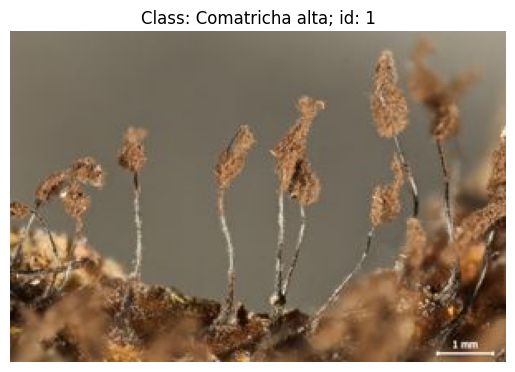

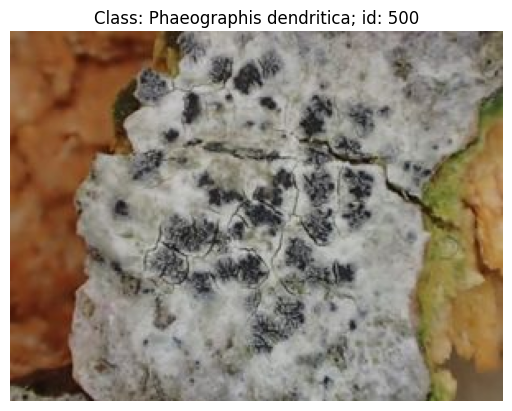

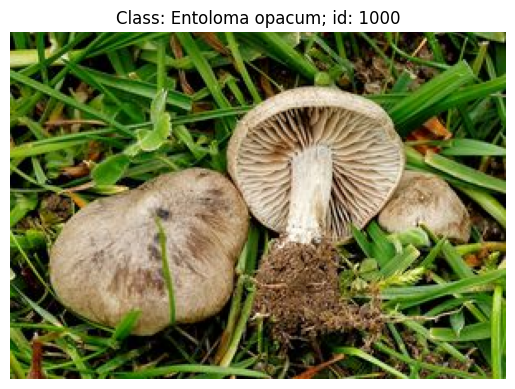

(None, None, None)

In [7]:
### Visualize few samples

train_dataset.show_sample(1), train_dataset.show_sample(500), train_dataset.show_sample(1000) 

## ⏳ 3. Precompute embeddings using BioCLIP

This code snippet demonstrates how to precompute image embeddings using the **BioCLIP** model. It loads the BioCLIP model, processes a given dataset, and stores the generated embeddings.

#### Steps:
1. **Initialize the Model**: The code sets up the **BioCLIP** model on the available device (GPU if available, else CPU). The model is then loaded and set to evaluation mode (`model.eval()`).
2. **Generate Embeddings**: 
   - The `generate_embeddings()` function loops through all the samples in the dataset.
   - For each image, it extracts the feature embeddings using `model.extract_features()`.
   - The extracted embeddings are stored in a pandas DataFrame with the image filename.
3. **Add Embeddings to Dataset**: The generated embeddings are then added to the respective dataset (`test_dataset` and `train_dataset`) using the `add_embeddings()` method.

#### Key Components:
- **BioCLIP model**: Used to extract embeddings for each image in the dataset.
- **Data Handling**: `im_names` stores image filenames, and `embs` stores the corresponding embeddings.
- **Embedding Storage**: Embeddings are stored in a pandas DataFrame, which is later merged with the dataset.

This process enables efficient embedding-based learning and retrieval tasks on the dataset.


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BioCLIP(device=device)
model.load()
model.eval()

def generate_embeddings(dataset):

    idxs = np.arange(len(dataset))
    im_names, embs = [], []
    for idx in tqdm(idxs):
        im, label, file_path, _ = dataset[idx]

        with torch.no_grad():
            feat = model.extract_features(im)
            
        # feat_quant = model.quantize_normalized_embedding(feat)

        im_names.append(os.path.basename(file_path))
        embs.append(feat.detach().cpu().numpy())

    embeddings = pd.DataFrame({'filename': im_names, 'embedding': embs})

    return embeddings

open_clip_config.json:   0%|          | 0.00/469 [00:00<?, ?B/s]

open_clip_pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

In [9]:
embeddings = generate_embeddings(test_dataset)
test_dataset.add_embeddings(embeddings)

100%|██████████| 1911/1911 [00:47<00:00, 40.15it/s]


In [10]:
embeddings = generate_embeddings(train_dataset)
train_dataset.add_embeddings(embeddings)

100%|██████████| 7819/7819 [03:12<00:00, 40.66it/s]


## 🏃🏻‍♂4. Run the few-shot classifier on the precomputed features

### 4.1 Classification with kNN

This code defines a **Nearest Neighbor (NN) Classifier** that uses precomputed embeddings to make predictions by comparing them to class prototypes. It employs **cosine similarity** to match test embeddings with training embeddings, making it suitable for few-shot and embedding-based classification tasks.

#### Key Steps:

1. **Classifier Initialization**:
   - The `NNClassifier` class is initialized with the training embeddings and sets up a similarity search index using **FAISS** (Facebook AI Similarity Search). 
   - The `build_index()` method creates an index for efficient similarity searches based on the cosine similarity between embeddings.

2. **Making Predictions**:
   - The `make_prediction()` method computes the similarity between each test embedding and the stored class prototypes. It returns the predicted class labels (`cls`) and confidence scores (`conf`) based on the similarity values.
   - **FAISS** is used to search the nearest prototypes for each test embedding.

3. **Generating Predictions for the Test Dataset**:
   - After initializing the classifier, predictions are made for the **test dataset** using the `make_prediction()` method.
   - Predicted labels are added to the test dataset (`test_dataset.df["preds"]`).

4. **Submission Generation**:
   - The predictions are grouped by `observationID` and formatted as a space-separated string of class IDs.
   - The predictions are saved to a CSV file for submission.

#### Key Components:
- **FAISS**: Efficiently computes nearest neighbor search using cosine similarity.
- **Embedding-based Classification**: The model leverages precomputed embeddings for each sample and matches them to class prototypes.
- **Prediction Confidence**: The similarity values serve as confidence scores for each prediction.

This approach is effective for embedding-based classification tasks where models make predictions based on the similarity of embeddings to predefined class prototypes.


In [11]:
class NNClassifier():
    def __init__(self, train_embeddings, device='cuda'):
        """
        :param cfg: config object, namespace
        :param train_embeddings: list of C torch arrays of shape [N_C, D] where N_C is the number of training samples
        of class C and D is the dimensionality of the embeddings
        """
        
        self.device = device
        self.index, self.idx2cls = self.build_index(train_embeddings)

    def make_prediction(self, embeddings, plot_sim_hist=False, ret_probs=False):
        """
        :param embeddings: torch.Tensor of shape (batch_size, n_channels, height, width)
        :return: probabilities of shape (batch_size, n_classes) computed based on
        the similarity of the embeddings to the class prototypes
        """
        # compute the similarity of each embedding to each prototype
        # embeddings - [N, D], class_prototypes - [C, D]
        similarities, indices = self.index.search(embeddings, 1)
        # get the classes for the indices
        cls = self.idx2cls[indices.squeeze()]
        # get the confidence of the prediction
        conf = similarities
        
        return cls, conf

    def build_index(self, train_dataset):
        idx2cls = train_dataset.df.category_id.values
        # concatenate the embeddings
        embs = np.array(train_dataset.df.embedding.values.tolist(), dtype=np.float32).squeeze()
        # build the index for cosine similarity search
        index = faiss.IndexFlatIP(embs.shape[1])
        index.add(embs)
        return index, idx2cls

In [12]:
classifier = NNClassifier(train_dataset, device='cpu')

cls, conf = classifier.make_prediction(np.array(test_dataset.df.embedding.values.tolist(), dtype=np.float32).squeeze())

In [13]:
test_dataset.df["preds"] = cls
submission = (
    test_dataset.df.groupby("observationID")["preds"]
    .apply(lambda x: " ".join(map(str, sorted(set(x)))))  # Sort and remove duplicates
    .reset_index()
)

submission = submission.rename(columns={"observationID": "observationId", "preds": "predictions"})
submission = submission.drop_duplicates(subset="observationId")
submission.to_csv("baseline-submission-with-nn.csv", index=None)

### 4.2 Classification with Prototypes

The `PrototypeClassifier` is a PyTorch model designed for **embedding-based classification** using **prototype-based classification**. It learns the class prototypes by averaging the embeddings of each class and uses cosine similarity to classify new embeddings based on their proximity to the prototypes.

#### Key Steps:

1. **Initialization**:
   - The model is initialized with a **train dataset** and computes class prototypes using embeddings of each class.
   - The `class_prototypes` are stored as **non-trainable parameters** (`requires_grad=False`), representing the average embeddings of each class.

2. **Embedding Retrieval**:
   - The `_get_classifier_embeddings()` method retrieves the embeddings for each class in the training dataset.
   - If a class has no embeddings, a zero vector is used as a placeholder for that class.

3. **Prototype Computation**:
   - The `get_prototypes()` method computes the **prototype** for each class by averaging its embeddings. These prototypes serve as the central representation of each class.

4. **Prediction**:
   - The `make_prediction()` method calculates the cosine similarity between each input embedding and all class prototypes.
   - The predicted class (`cls`) is the one with the highest similarity, and the prediction confidence (`conf`) is derived from the maximum softmax probability over the similarities.

#### Key Components:
- **Class Prototypes**: Each class is represented by its average embedding, which acts as the class prototype.
- **Cosine Similarity**: The model uses cosine similarity to compare input embeddings with class prototypes and determine the predicted class.
- **Prediction Confidence**: The confidence is computed using the softmax of the cosine similarity values, providing a measure of certainty for each prediction.

This classifier is well-suited for tasks where class prototypes (average embeddings) can effectively represent the classes, and it works well with embedding-based models for few-shot or metric learning tasks.


In [14]:
class PrototypeClassifier(torch.nn.Module):
    def __init__(self, train_dataset, device='cuda'):
        super().__init__()
        self.device = device
        self.train_dataset = train_dataset

        class_embeddings, _ = self._get_classifier_embeddings(train_dataset)
        self.class_prototypes = torch.nn.Parameter(self.get_prototypes(class_embeddings), requires_grad=False)

    def _get_classifier_embeddings(self, dataset_train):
        class_embeddings = []
        empty_classes = []
        n_classes = min(torch.inf, dataset_train.n_classes)
        for cls in range(n_classes):
            cls_embs = dataset_train.get_embeddings_for_class(cls)
            if len(cls_embs) == 0:
                # if no embeddings for class, use zeros
                empty_classes.append(cls)
                class_embeddings.append(torch.zeros(1, dataset_train.emb_dim))
            else:
                class_embeddings.append(torch.tensor(np.vstack(cls_embs.values)))
        return class_embeddings, empty_classes

    def get_prototypes(self, embeddings):
        return torch.stack([class_embs.mean(dim=0) for class_embs in embeddings])

    def make_prediction(self, embeddings):
        similarities = torch.nn.functional.cosine_similarity(embeddings, self.class_prototypes, dim=-1)
        cls = torch.argmax(similarities, dim=1)
        conf = torch.nn.functional.softmax(similarities, dim=1).max(dim=1).values
        return cls, conf

In [15]:
classifier = PrototypeClassifier(train_dataset, device='cpu')
cls, conf = classifier.make_prediction(torch.tensor(np.array(test_dataset.df.embedding.values.tolist(), dtype=np.float32)))

In [17]:
test_dataset.df["preds"] = cls
submission = (
    test_dataset.df.groupby("observationID")["preds"]
    .apply(lambda x: " ".join(map(str, sorted(set(x)))))  # Sort and remove duplicates
    .reset_index()
)

submission = submission.rename(columns={"observationID": "observationId", "preds": "predictions"})
submission = submission.drop_duplicates(subset="observationId")
submission.to_csv("baseline-submission-with-prototypes.csv", index=None)